# Predicting helpful reviews using machine learning and specifical classification
----------------------
## Problem
### It has been showed that over last past 10 years, global retail e-commerce has been explosive growth. Without experience of product commonalities, customers will heavily rely on other reviewers for the decision making for the online shopping. However, with amount of information from reviewers, it is important for a website to identify the useful, valid, and reliable reviews to save help customers. Useful reviews also can in turn to help business to improve their products and understand customers' need.

## Goal
### The goal of this project is to mine 5 million book reviews from Amazon.com to understand the features of reviews for helpfulness and develop preliminary classification models to predict helpfulness of a review foods

## Data source
### http://jmcauley.ucsd.edu/data/amazon/

-------------------------------------------------
## _1. Preparing Amazon book dataset_

### 1.1. Load json data from bigquery
### 1.2. Check data
### 1.3. Label sentiment of reviewer rating for a product
        rating as 1 and 2 ==> negative
        rating as 3       ==> neural
        rating as 4 and 5 ==> positive
### 1.4. Label helpful and unhelpful reviews
        helful_vot/total vot > 50% ==> helpfulness 
        helful_vot/total vot <= 50% ==> unhelpfulness

In [1]:
##########################################
## 1.1 CONFIG FOR BIGQUERY
##########################################

## Setting configuration for bigquery
## Save data as dataframe 

from bigquery import get_client

# BigQuery project id as listed in the Google Developers Console.
project_id = 'springboard-project'

# Service account email address as listed in the Google Developers Console.
service_account = 'python-pandas@springboard-project.iam.gserviceaccount.com'

# PKCS12 or PEM key provided by Google.
key = '/Users/tancy/SpringBoardProject-b3a58f067389.p12'

client = get_client(project_id, service_account=service_account,
                    private_key_file=key, readonly=True)

In [2]:
##########################################
## BIGQUERY TO DATAFRAME
##########################################

import pandas as pd

# to communicate with Google BigQuery
from pandas.io import gbq

amazon_book_sample_query = """
SELECT
    reviewerID,
    asin,
    unixReviewTime,
    overall,
    reviewText,
    summary,
    helpful_vot,
    tot_vot,

FROM
    (SELECT * FROM [springboard-project:AmazonReview.book2_small_sample])
    
"""

try:
    ABS_df = gbq.read_gbq(amazon_book_sample_query, project_id=project_id)
except:
    print 'Error reading the dataset'


Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 12.0% done. Elapsed 9.2 s.
  Got page: 2; 23.0% done. Elapsed 16.65 s.
  Got page: 3; 34.0% done. Elapsed 23.65 s.
  Got page: 4; 46.0% done. Elapsed 31.37 s.
  Got page: 5; 57.0% done. Elapsed 38.47 s.
  Got page: 6; 69.0% done. Elapsed 46.95 s.
  Got page: 7; 80.0% done. Elapsed 56.61 s.
  Got page: 8; 92.0% done. Elapsed 63.63 s.
  Got page: 9; 100.0% done. Elapsed 69.19 s.
Got 100225 rows.

Total time taken 73.92 s.
Finished at 2016-11-23 20:18:56.


In [3]:
##########################################
## 1.2 CHECK DATA IN PANDAS
############################################

# change column name 
ABS_df = ABS_df.rename(columns={'overall': 'reviewRating'})

print "Total data:", str(ABS_df.shape)
ABS_df.head(2)


Total data: (100225, 8)


,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1


In [4]:
##########################################
## 1.3 LABEL SENTIMENT OF REVIEW
##########################################

def label_Sentiment(row):
    if row['reviewRating'] <= 2:
           return "negative"
    if row['reviewRating'] == 3:
           return "neural"
    if row['reviewRating'] >= 4:
           return "positive"

ABS_df['sentiment'] = ABS_df.apply(label_Sentiment, axis=1)


In [5]:
##########################################
## 1.4 LABEL HELPFULNESS
#########################################
import numpy as np

def label_Helpfulness(row):
    if row['help_prop'] > 0.5:
           return 'helpful'
    else: 
           return 'unhelpful'

ABS_df['help_prop'] = ABS_df.helpful_vot.div(ABS_df.tot_vot, axis=0)
#ABS_df = ABS_df[np.isfinite(ABS_df['help_prop'])] ### should we exclude reviews with no vote ? ###
ABS_df['helpIndx'] = ABS_df.apply(label_Helpfulness, axis=1)

ABS_df.head(2)

,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot,sentiment,help_prop,helpIndx
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1,positive,1.0,helpful
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1,positive,1.0,helpful


-----------------
## _2. Preliminary Analysis_
### 2.1 Descriptive statistics
### 2.2 Distribution of reviewer rating (1 to 5)
### 2.3 Distribution of helful proportion for reviews
### 2.4 Distribution of reviewer rating for helpfulness
### 2.5 An example of a product for reviewer rating and helpfulness
### 2.6 Helpfulness for the length of text

In [6]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print "================================================"

### Total reviews
print "Number of reviews:" + str(len(ABS_df))

### How many unique reviewers?
reviewer_prop = float(len(ABS_df.reviewerID.unique()))/len(ABS_df.index)
print "Prop of unique reviewers:" + str(round(reviewer_prop,3))

### How many unique products?
product_prop = float(len(ABS_df.asin.unique()))/len(ABS_df.index)
print "Prop of unique products:" + str(round(product_prop,3))

### average star score
print("Average rating score: " + str(round(ABS_df.reviewRating.mean(),3)))

### average helpful 
print("Average helpful pcd:" + str(round(ABS_df.help_prop.mean(),3)))
print "================================================"

Number of reviews:100225
Prop of unique reviewers:0.768
Prop of unique products:0.666
Average rating score: 4.251
Average helpful pcd:0.734


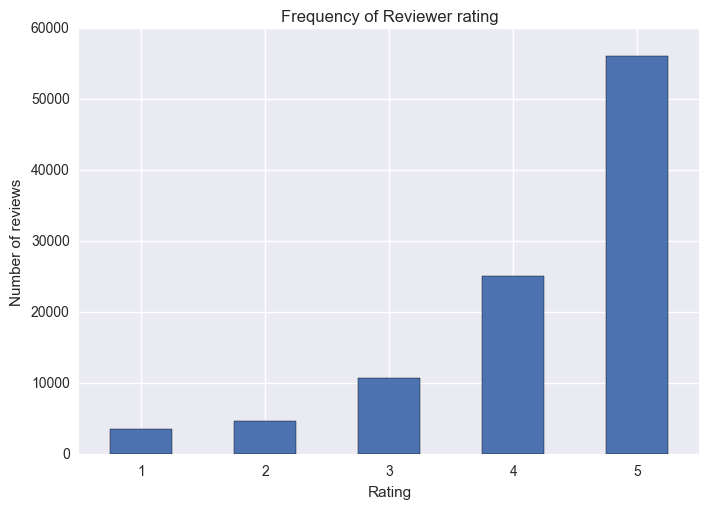

In [7]:
##########################################
## 2.2 DISTRIBUTION OF REVIEWER RATING
########################################## 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ABS_df.groupby('reviewRating').size().plot(kind='bar')
plt.title("Frequency of Reviewer rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

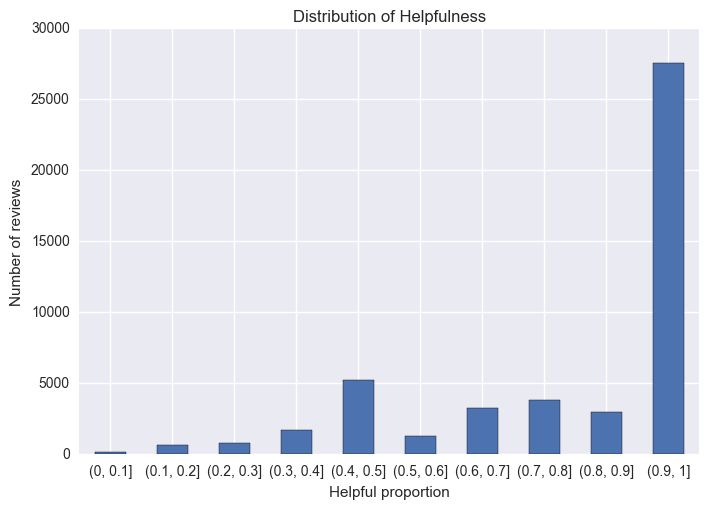

In [8]:
##########################################
## 2.3 DISTRIBUTION OF HELPFULNESS
########################################## 

cutoff = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


Dist_help = ABS_df.groupby([pd.cut(ABS_df['help_prop'], bins = cutoff)]).size()
Dist_help.plot(kind='bar')

plt.title("Distribution of Helpfulness")
plt.xlabel("Helpful proportion")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

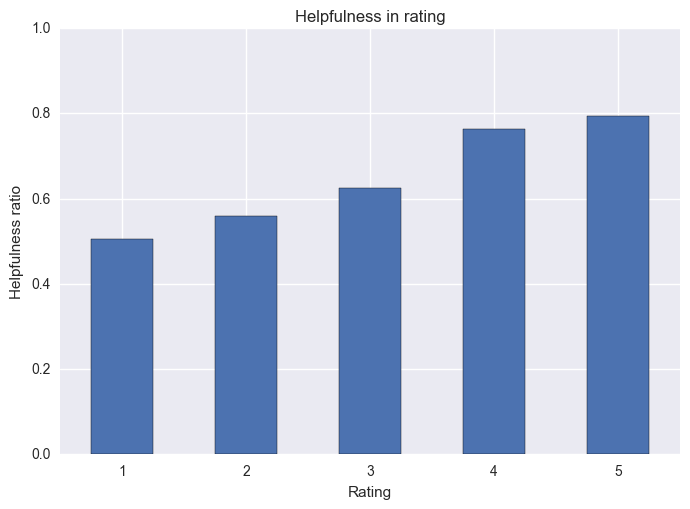

In [9]:
##########################################
## 2.4 DISTRIBUTION OF RATING FOR HELPFULNESS
########################################## 

ABS_df.groupby('reviewRating')['help_prop'].mean().plot(kind='bar')
plt.title("Helpfulness in rating")
plt.xlabel("Rating")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.show()

In [10]:
##########################################
## 2.5 A PRODUCT FOR REVIEWER RATING AND HELPFULNESS
########################################## 
ABS_df.groupby('asin').size().sort_values(ascending=False).head(5)

asin
0439023483    84
030758836X    77
0375831002    63
0385537859    59
038536315X    56
dtype: int64

/Users/tancy/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


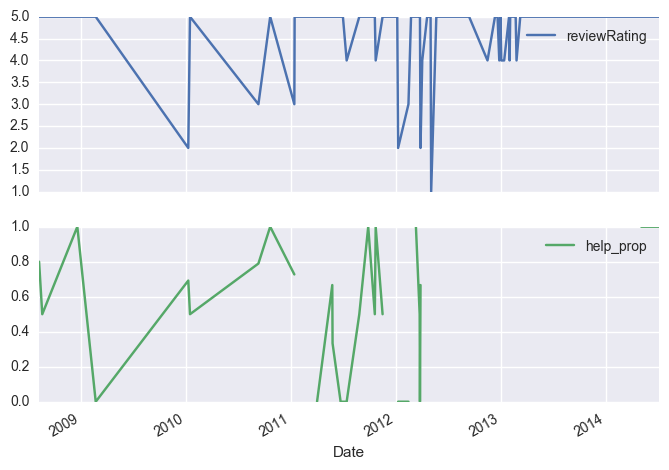

In [11]:
OneProduct = ABS_df[ABS_df.asin=='0439023483']
OneProduct['Date'] = pd.to_datetime(OneProduct['unixReviewTime'],unit='s')
OneProduct_mean = OneProduct.groupby("Date")['reviewRating','help_prop'].mean()
OneProduct_mean.head()
OneProduct_mean.plot(subplots=True)
plt.show()

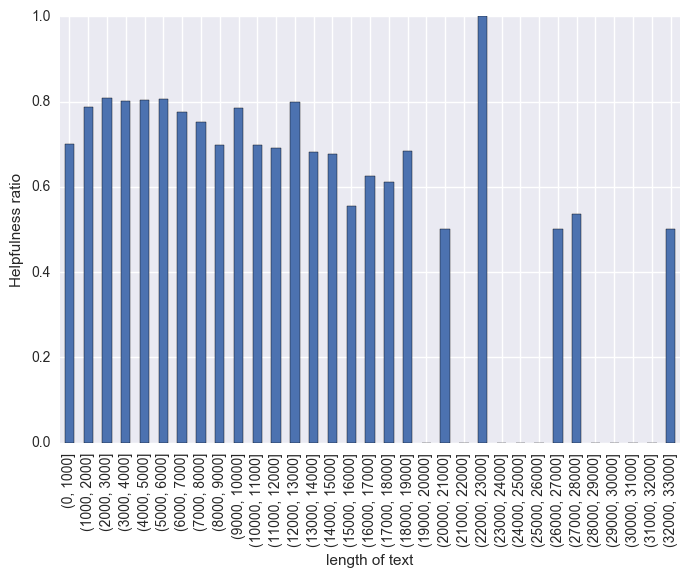

In [12]:
##########################################
## 2.6 HELPFULNESS FOR LENGTH OF TEXT
########################################## 
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = max(ABS_df.text_len)
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen+1000,1000)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of text")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])

plt.show()

-----------
## _3. Text Preprocessing_
### 3.1 Subset data for modeling
        total vote >=2 & text_len >=2
### 3.2 Statistic description of subset data 
### 3.3 Text length between helpfulness and unhelpfulness
### 3.4 Pair correlation between 'reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx'

In [13]:
###################
## 3.1 SUBSET DATA
###################

## select total vote >= 2
subset_ABS_df = ABS_df[(ABS_df.tot_vot>=2) & (ABS_df.text_len>=2)]

class_counts = subset_ABS_df.groupby('helpIndx').size()

print "================================================"
print class_counts
print "================================================"


helpIndx
helpful      24736
unhelpful    10076
dtype: int64


In [14]:
##########################
## 3.2 STATISTIC SUMMARY 
#########################
from pandas import set_option
set_option('display.width', 100)
set_option('precision', 3)
print subset_ABS_df.groupby('helpIndx').describe()

                 help_prop  helpful_vot  reviewRating   text_len    tot_vot  unixReviewTime
helpIndx                                                                                   
helpful   count  24736.000    24736.000     24736.000  24736.000  24736.000       2.474e+04
          mean       0.875       10.632         4.149   1310.037     12.370       1.248e+09
          std        0.143       31.550         1.178   1323.246     35.336       1.274e+08
          min        0.509        2.000         1.000     21.000      2.000       8.507e+08
          25%        0.750        2.000         4.000    458.750      3.000       1.157e+09
          50%        0.938        4.000         5.000    920.000      5.000       1.285e+09
          75%        1.000        9.000         5.000   1713.000     11.000       1.358e+09
          max        1.000     1744.000         5.000  32179.000   1853.000       1.406e+09
unhelpful count  10076.000    10076.000     10076.000  10076.000  10076.000     

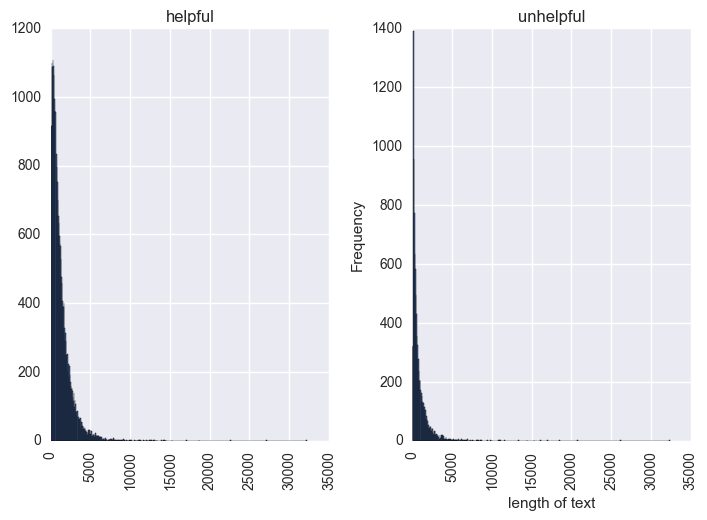

In [15]:
##########################
## 3.3 TEXT LENGTH  
########################### 
subset_ABS_df.hist(column='text_len', by='helpIndx', bins=500)

plt.xlabel("length of text")
plt.ylabel("Frequency")
plt.show()


In [16]:
############################
## 3.4 PAIRWISE PEARSON CORR  
########################### 
names = ['reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx']
data = subset_ABS_df[names]
data[['helpIndx']] = np.where(data['helpIndx'] == 'helpful', 1, 0)
set_option('display.width', 100)
set_option('precision', 3)
correlations = data.corr(method='pearson')
print "================="
print(correlations)
print "================="

              reviewRating  help_prop  helpful_vot  text_len  tot_vot  helpIndx
reviewRating         1.000      0.312       -0.017     0.005   -0.086     0.217
help_prop            0.312      1.000        0.126     0.137    0.032     0.837
helpful_vot         -0.017      0.126        1.000     0.152    0.969     0.141
text_len             0.005      0.137        0.152     1.000    0.148     0.161
tot_vot             -0.086      0.032        0.969     0.148    1.000     0.070
helpIndx             0.217      0.837        0.141     0.161    0.070     1.000


/Users/tancy/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tancy/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


----------
## _4. Bag of words_
### 4.1 Function to clean reviews to words
    replaces all punctuation with spaces
    converts the input string to lower case
    splits the string to words
    removes stop-words
### 4.2 Process to clean review
### 4.3 Manipulate clean text to be string instead of list (for count vectorize)
### 4.4 Extract features from strings
### 4.5 Transform a count matrix to tf-idf representation
### 4.6 Indentify top 20 features
### 4.7 word cloud of top 100 features

In [17]:
##########################################
## 4.1 FUNCTION TO CLEAN REVIEWS TO WORDS
##########################################

import re, string, nltk
from nltk.corpus import stopwords
    
def review2words(raw_review):
    remove = string.punctuation
    # keep surprise characters
    remove = remove.replace("!", "") # don't remove !
    remove = remove.replace("?", "") # don't remove ?
    pattern = r"[{}]".format(remove) # create the pattern

    # 1. replaces punctuation with spaces
    review_words=raw_review.str.replace(pattern, "")

    # 2. converts the input string to lower case
    review_words_low = review_words.str.lower()

    # 3. splits the string and ? ! to words 
    review_words_low2 = review_words_low.apply(nltk.word_tokenize)
    
    # 4. removes stop-words
    stops = set(stopwords.words("english")) # searching a set is faster than a list
    meaningful_words = review_words_low2.apply(lambda x: [w for w in x if w not in stops])    
    
    ## if necessary to do following clean text ##
    # 5. Stemming - strip off affixes
    # porter = nltk.PorterStemmer()
    # meaningful_words2 = meaningful_words.apply(lambda x: [porter.stem(t) for t in x])
    
    # 6. Lemmatizing - the word is from a dictionary 
    # wnl = nltk.WordNetLemmatizer()
    # clean_words = meaningful_words2.apply(lambda x: [wnl.lemmatize(t) for t in x])
    
    return(meaningful_words)


In [18]:
##########################################
## 4.2 PROCESS TO CLEAN REVIEWS TO WORDS
##########################################
clean_s = review2words(subset_ABS_df.reviewText)
clean_s.name="cleanText"
clean_s[:3]
## merge back to dataframe
# clean_ABS_df = pd.concat([ABS_df,clean_s],axis=1)
# clean_ABS_df.head(3)

2    [got, seventy, six, per, cent, book, couldnt, ...
3    [thought, story, really, well, told, totally, ...
8    [latest, book, former, president, jimmy, carte...
Name: cleanText, dtype: object

In [19]:
###############################################################################
## 4.3 MANIPULATE CLEAN TEXT TO BE STRING INSTEAD OF LIST (FOR count vectorize)
###############################################################################
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text = make_string(clean_s)

In [20]:
####################################
## 4.4 EXTRACT FEATURES FROM STRING
####################################
## generate single words along with 2 and 3 word phrases, 
## select max 5000 terms 

from scipy.sparse import coo_matrix, vstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 3), max_features = 5000,
                             token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'") # keep ? and !

tfidf_review_text = vectorizer.fit_transform(final_text)
feature_names = vectorizer.get_feature_names()


print "================================================"
print "Number of features:", len(feature_names)
print "Ten example features:", feature_names[0:10]
print "================================================"
# vectorizer.vocabulary_

Number of features: 5000
Ten example features: [u'!', u'! !', u'! ! !', u'! ?', u'! also', u'! book', u'! cant', u'! cant wait', u'! dont', u'! great']


In [21]:
########################################
## 4.5 TRANSFORM A COUNT MATRIX TO A TF
########################################

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_matrix = transformer.fit_transform(tfidf_review_text)

print "================================================"
print 'sparse matrix shape:', tfidf_matrix.shape # one row per review, one column per phrase
print 'number of non-zeros:', tfidf_matrix.nnz
print 'sparsity: %.2f%%' % (100.0 * tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print "================================================"

sparse matrix shape: (34812, 5000)
number of non-zeros: 1918619
sparsity: 1.10%


In [22]:
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
#len(phrase_scores)

In [23]:
############################################################################
## 4.6 IDENTIFY TOP 20 INFORMATIVE FEATURES AND THEIR INVERSE DOCUMENT FREQ
############################################################################

top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(feature_names[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

print pd.DataFrame(top)[:20]

     Feature_Name  Score
0    descriptions  0.258
1           novel  0.257
2         looking  0.190
3          sophie  0.189
4             man  0.183
5          brains  0.179
6      book reads  0.178
7    book couldnt  0.176
8           dance  0.176
9   romance novel  0.174
10        schools  0.163
11           teen  0.160
12        holding  0.159
13      evolution  0.159
14            per  0.159
15          grown  0.156
16     reads like  0.156
17  psychological  0.154
18      direction  0.148
19            way  0.143


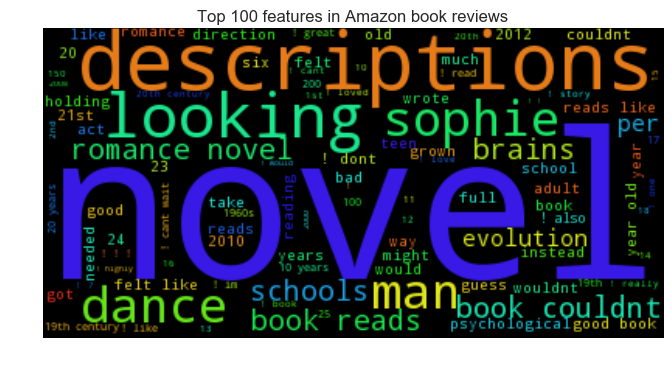

(0.0, 1.0, 0.0, 1.0)

In [25]:
############################################
## 4.7 PLOT WORDCLOUD OF TOP 100 FEATURES
############################################

### need wordcloud package by Andreas Mueller
### need Python’s imaging library PIL

top_wordDict = dict(zip(top_words, top_score))

from wordcloud import WordCloud
#wordcloud.generate_from_frequencies(dictionary.items())
wordcloud_fig = WordCloud().generate_from_frequencies(top_wordDict.items())

#plt.figure(1)
plt.imshow(wordcloud_fig)
plt.title("Top 100 features in Amazon book reviews")
plt.show()
plt.axis('off')

## _5 Supervised Learning model_
### 5.1 Split text into train and test
### 5.2 Set customer features to model parameters
### 5.3 Test model 1: MultinomialNB
### 5.4 Test model 2: Linear SVM

In [ ]:


from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

#from sklearn.tree import DecisionTreeClassifier 

In [30]:
####################################
## 5.1 SPLIT TEXT INTO TRAIN AND TEST
####################################

from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 

review_train, review_test, helpIndx_train, helpIndx_test = \
    train_test_split(subset_ABS_df['reviewText'], subset_ABS_df['helpIndx'], test_size=0.2)

print "TrainSet TestSet:", len(review_train), len(review_test)

TrainSet TestSet: 27849 6963


In [ ]:
#################################################
## 5.2 SET CUSTOMER FEATURES TO MODEL PARAMETERS
################################################

### not successful yet

from sklearn.base import BaseEstimator, TransformerMixin

class TextLengthExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass#self.vars = vars  # e.g. pass in a column name to extract

    def transform(self, subset_ABS_df, y=None):
        return np.mean(subset_ABS_df['text_len'])  # where the actual feature extraction happens

    def fit(self, subset_ABS_df, y=None):
        return self  # generally does nothing

In [31]:
#################################################
## 5.3 TEST MODEL_1: MultinomialNB
################################################

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline_NB = Pipeline([
    ('count', CountVectorizer(binary=False, ngram_range=(1, 3), min_df = 0.001,
                             token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    #('feats', FeatureUnion([('lenText', TextLengthExtractor())])),
    ('classifier', MultinomialNB())  # classifier
])

In [35]:
### cross validation for MultinomialNB
%time 
scores_NB = cross_val_score(pipeline_NB,  # steps to convert raw reviews into models
                         review_train,  # training data
                         helpIndx_train,  # training labels
                         cv=3,  # split data randomly into 3 parts: 2 for training, 1 for scoring 
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )


CPU times: user 6 µs, sys: 10 µs, total: 16 µs
Wall time: 35 µs


In [37]:
print "================================"
print "MultinomialNB"
print "scores:", scores_NB
print "Mean, Std:", scores_NB.mean(), scores_NB.std()
print "================================"

MultinomialNB
scores: [ 0.71230073  0.71302381  0.7133161 ]
Mean, Std: 0.71288021169 0.000426774976716


In [38]:
#################################################
## 5.4 TEST MODEL_2: linear SVM
################################################
from sklearn.svm import SVC, LinearSVC
pipeline_svm = Pipeline([
    ('count', CountVectorizer(binary=False, ngram_range=(1, 3), min_df = 0.001,
                             token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    #('feats', FeatureUnion([('lenText', TextLengthExtractor())])),
    ('classifier', SVC()), 
])

In [39]:
### cross validation for linear SVM
%time 
scores_SVM = cross_val_score(pipeline_svm,  # steps to convert raw reviews into models
                         review_train,  # training data
                         helpIndx_train,  # training labels
                         cv=3,  # split data randomly into 3 parts: 2 for training, 1 for scoring 
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 36 µs


In [40]:
print "================================"
print "linear SVM"
print "scores:", scores_SVM
print "Mean, Std:", scores_SVM.mean(), scores_SVM.std()
print "================================"

linear SVM
scores: [ 0.71057734  0.71054616  0.71062271]
Mean, Std: 0.710582069208 3.14304078964e-05


In [ ]:
#################################################
## 5.4 TEST MODEL_3: LogistRegression
################################################

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

pipeline_logreg = Pipeline([
    ('count_text', CountVectorizer(binary=False, ngram_range=(1, 3), min_df = 0.001,
                             token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', logreg),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
## cross validation 
%time 
scores_logreg = cross_val_score(pipeline_logreg,  # steps to convert raw reviews into models
                         review_train,  # training data
                         helpIndx_train,  # training labels
                         cv=3,  # split data randomly into 3 parts: 2 for training, 1 for scoring 
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )

In [ ]:
print "================================"
print "LogisticRegression"
print "scores:", scores_logreg
print "Mean, Std:", scores_logreg.mean(), scores_logreg.std()
print "================================"

In [ ]:
#### Need more analysis of model fitting
#### grid search for the best parameters of models
#### spark to handle huge data